In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade keras

In [3]:
!pip install wfdb

     |████████████████████████████████| 137 kB 5.2 MB/s 
     |████████████████████████████████| 11.2 MB 34.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 5.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.0
    Uninstalling matplotlib-3.5.0:
      Successfully uninstalled matplotlib-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
cd drive/MyDrive/ECG

/content/drive/MyDrive/ECG


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wfdb

In [7]:
data_1 = []
filename = "209"
file = open('data/' + filename + '.txt', 'r')
while True:
    line = file.readline()
    if not line: 
        break
    data_1.append([line[3:12], int(line[15:21]), line[26]])

data_2 = []
filename = "209"
file = open('data/' + filename + '.txt', 'r')
while True:
    line = file.readline()
    if not line: 
        break
    data_2.append([line[3:12], int(line[15:21]), line[26]])

In [8]:
normal = []
filename = "209"
sig, fields = wfdb.rdsamp('data/' + filename)
for i in range(2, 80):
    if data_1[i][2] != "N" or data_1[i + 1][2] != "N":
        break
    for j in range(data_1[i][1], data_1[i + 1][1]):
        normal.append([sig[j][0], sig[j][1]])

abnormal = []
abnormal_label = []
filename = "209"
sig, fields = wfdb.rdsamp('data/' + filename)
for i in range(900, 1050):
    for j in range(data_2[i][1], data_2[i + 1][1]):
        abnormal.append([sig[j][0], sig[j][1]])
        if j >= (data_2[i][1] + data_2[i + 1][1]) // 2: 
                if data_2[i + 1][2] == "N":
                    abnormal_label.append("0")
                else:
                    abnormal_label.append("1")
        else:
                if data_2[i][2] == "N":
                    abnormal_label.append("0")
                else:
                    abnormal_label.append("1")

In [9]:
print(len(normal), len(abnormal))

18097 25525


In [10]:
train = pd.DataFrame(normal, columns=["Target1", "Target2"])
test = pd.DataFrame(abnormal, columns=["Target1", "Target2"])
label = pd.DataFrame(abnormal_label, columns=["label"])

In [11]:
test_raw = pd.concat([test,label], axis = 1, ignore_index=False)

In [12]:
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (18097, 2)
Test dataset shape: (25525, 2)


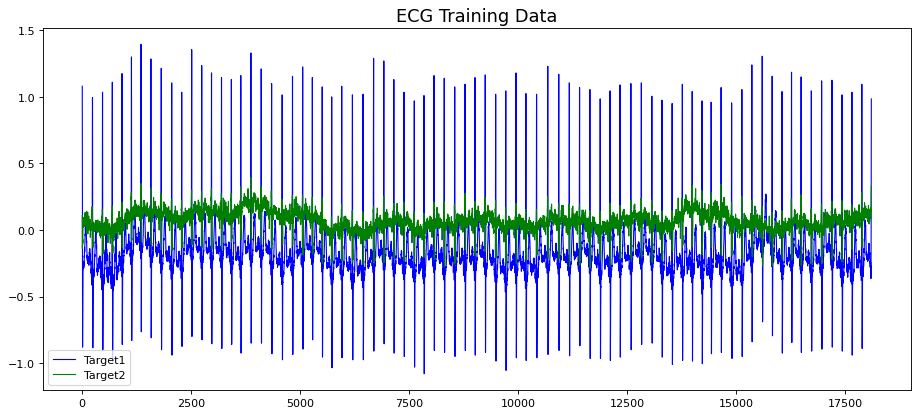

In [13]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.plot(train['Target2'], label='Target2', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('ECG Training Data', fontsize=16)
plt.show()

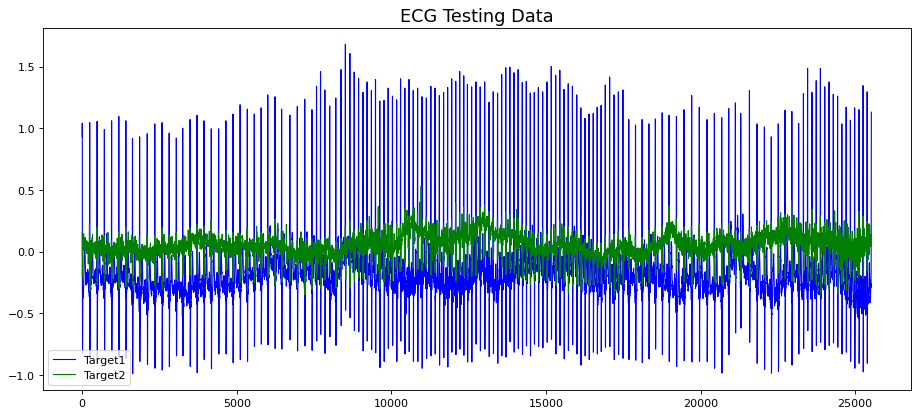

In [14]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.plot(test['Target2'], label='Target2', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('ECG Testing Data', fontsize=16)
plt.show()

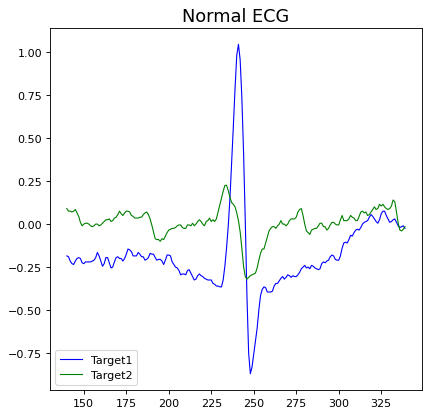

In [15]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=80)
ax.plot(test['Target1'][140:340], label='Target1', color='blue', animated = True, linewidth=1)
ax.plot(test['Target2'][140:340], label='Target2', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Normal ECG', fontsize=16)
plt.show()

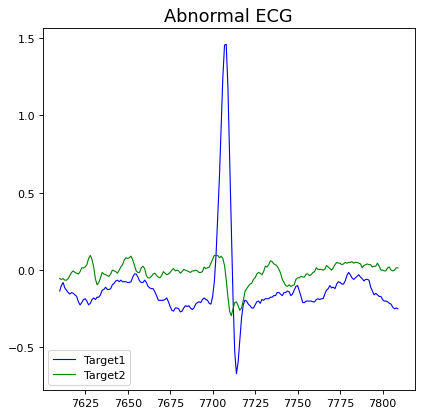

In [16]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=80)
ax.plot(test['Target1'][7610:7810], label='Target1', color='blue', animated = True, linewidth=1)
ax.plot(test['Target2'][7610:7810], label='Target2', color='green', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Abnormal ECG', fontsize=16)
plt.show()

In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import _joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

seed(10)
tf.random.set_seed(10)

In [18]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [19]:
strategy = tf.distribute.TPUStrategy(resolver)

In [20]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "real_scaler_data"
_joblib.dump(scaler, scaler_filename)

['real_scaler_data']

In [21]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [22]:
train_timesteps = X_train.shape[0]
train_n_features = X_train.shape[1]

In [23]:
timesteps = 300
train_X, train_y = temporalize(X = X_train, y = np.zeros(len(X_train)), lookback = timesteps)

n_features = 2
train_X = np.array(train_X)
X_train = train_X.reshape(train_X.shape[0], timesteps, n_features)

In [24]:
test_timesteps = X_test.shape[0]
test_n_features = X_test.shape[1]

In [25]:
test_X, test_y = temporalize(X = X_test, y = np.zeros(len(X_test)), lookback = timesteps)

test_X = np.array(test_X)
X_test = test_X.reshape(test_X.shape[0], timesteps, n_features)

In [26]:
from keras.layers import Dropout
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(300, activation='tanh', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00), go_backwards=True)(inputs)
    L1 = Dropout(0.2)(L1)
    L2 = LSTM(100, activation='tanh', return_sequences=True)(L1)
    L2 = Dropout(0.2)(L2)
    L3 = LSTM(50, activation='tanh', return_sequences=False)(L2)
    L3 = Dropout(0.2)(L3)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(50, activation='tanh', return_sequences=True)(L4)
    L6 = LSTM(100, activation='tanh', return_sequences=True)(L5)
    L7 = LSTM(300, activation='tanh', return_sequences=True, go_backwards=True)(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L7)
    model = Model(inputs=inputs, outputs=output)
    return model

In [27]:
import keras
from tensorflow.keras.optimizers import Adam
import os
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  model = autoencoder_model(X_train)
  model.compile(optimizer=Adam(lr=0.0001,beta_1=0.9, beta_2=0.999), loss='mae')
  model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 2)]          0         
                                                                 
 lstm (LSTM)                 (None, 300, 300)          363600    
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 300, 100)          160400    
                                                                 
 dropout_1 (Dropout)         (None, 300, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
nb_epochs = 20
batch_size = 128
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/20
133/133 [==============================] - 54s 283ms/step - loss: 0.1145 - val_loss: 0.0695
Epoch 2/20
133/133 [==============================] - 28s 211ms/step - loss: 0.0699 - val_loss: 0.0668
Epoch 3/20
133/133 [==============================] - 28s 211ms/step - loss: 0.0645 - val_loss: 0.0643
Epoch 4/20
133/133 [==============================] - 28s 211ms/step - loss: 0.0626 - val_loss: 0.0630
Epoch 5/20
133/133 [==============================] - 28s 210ms/step - loss: 0.0617 - val_loss: 0.0613
Epoch 6/20
133/133 [==============================] - 28s 211ms/step - loss: 0.0612 - val_loss: 0.0609
Epoch 7/20
133/133 [==============================] - 28s 211ms/step - loss: 0.0606 - val_loss: 0.0626
Epoch 8/20
133/133 [==============================] - 28s 211ms/step - loss: 0.0603 - val_loss: 0.0626
Epoch 9/20
133/133 [==============================] - 28s 211ms/step - loss: 0.0602 - val_loss: 0.0614
Epoch 10/20
133/133 [==============================] - 28s 211ms/step - l

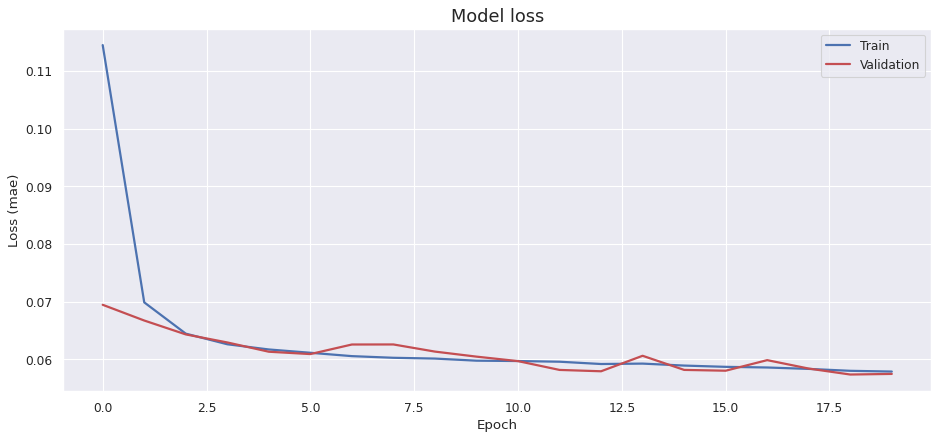

In [29]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [30]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [31]:
PX_train = flatten(X_train)

In [32]:
X_pred = model.predict(X_train)

In [33]:
X_pred = flatten(X_pred)

In [34]:
X_pred.shape

(17796, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.1)

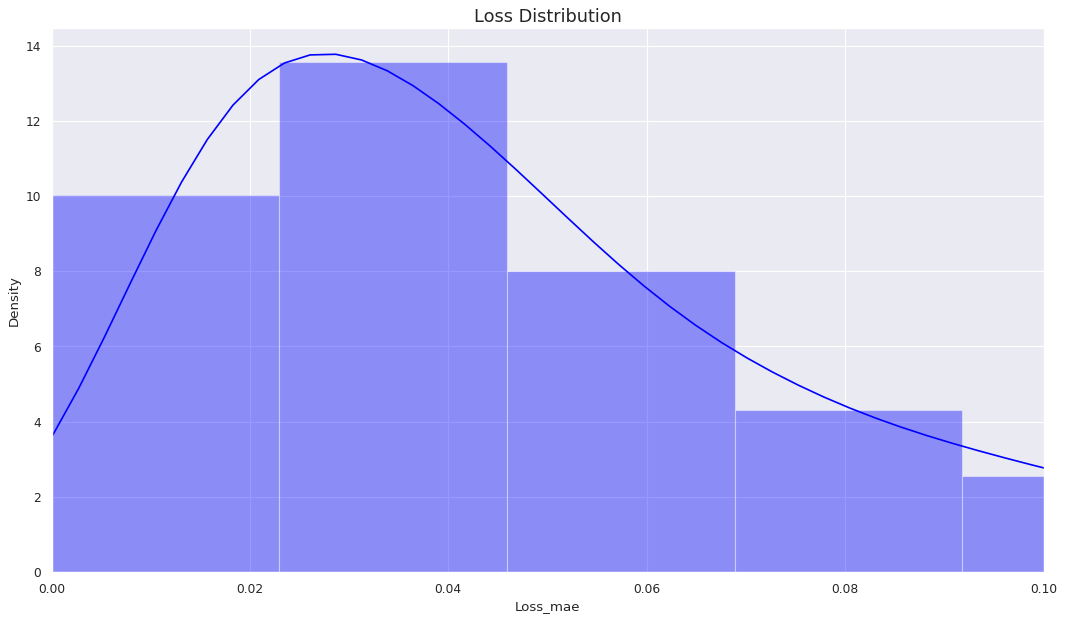

In [35]:
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train[0:X_pred.shape[0]].index

scored = pd.DataFrame(index=train[0:X_pred.shape[0]].index)
Xtrain = PX_train.reshape(PX_train.shape[0], PX_train.shape[1])
scored['Loss_mae'] = np.mean(np.abs(X_pred-PX_train), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.1])

In [36]:
print('anomaly threshold = {}'.format(np.percentile(scored,100)))
threshold = np.percentile(scored,100)


anomaly threshold = 0.45884747708651263


In [37]:
X_pred = model.predict(X_test)
X_pred = flatten(X_pred)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test[0:X_pred.shape[0]].index

scored = pd.DataFrame(index=test.index)

X_test_ = flatten(X_test)

Xtest_ = X_test_.reshape(X_test_.shape[0], X_test_.shape[1])


In [38]:
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest_), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
0,0.017225,0.458847,False
1,0.037781,0.458847,False
2,0.035772,0.458847,False
3,0.036857,0.458847,False
4,0.035865,0.458847,False


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:486: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(self.ylim)


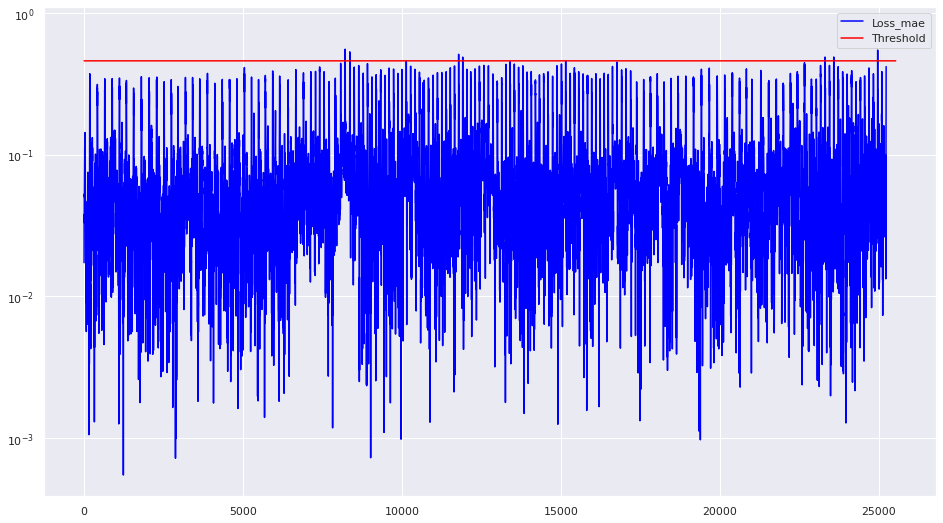

In [48]:
scored[0:].plot(logy=True,  figsize=(16,9), ylim=[0,1.10], color=['blue','red'])

6341
6581
7484
17869
21212
21439


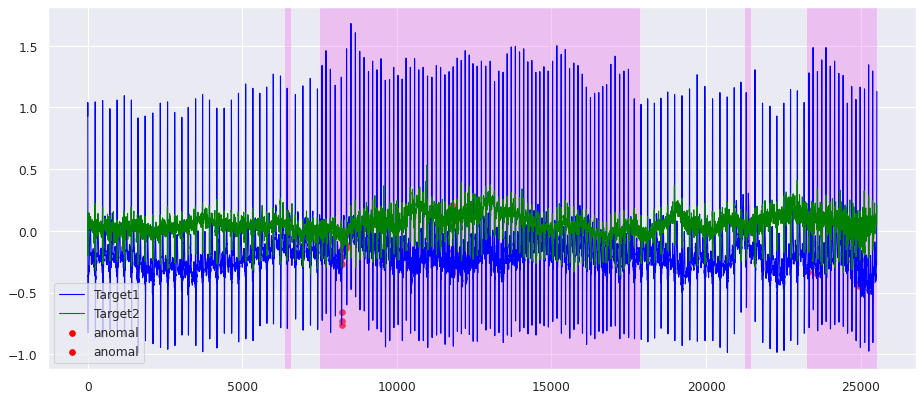

In [49]:
test_ = test_raw[0:]
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target1'].index,test_[scored['Anomaly']==1]['Target1'],label='anomal',marker='.', color='red', s = 100)

ax.plot(test_['Target2'], label='Target2', color='green', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target2'].index,test_[scored['Anomaly']==1]['Target2'],label='anomal',marker='.', color='red', s = 100)

plt.legend(loc='lower left')
ax.set_title('', fontsize=16)

p = list(test_[test_['label'] == "1"].index)
sec = []
ano = []
for i in range(len(p)):
    if len(sec) == 0:
        sec.append(p[i])
    elif sec[-1] + 1 == p[i]:
        sec.append(p[i])
    else:
        plt.axvspan(min(sec), max(sec), facecolor='violet', alpha=0.4)
        print(min(sec))
        for k in range(min(sec), max(sec)+1):
            ano.append(k)
        print(max(sec))
        sec.clear()
        sec.append(p[i])
    if i == len(p) - 1:
        plt.axvspan(min(sec), max(sec), facecolor='violet', alpha=0.4)
        for k in range(min(sec), max(sec)+1):
            ano.append(k)
plt.show()

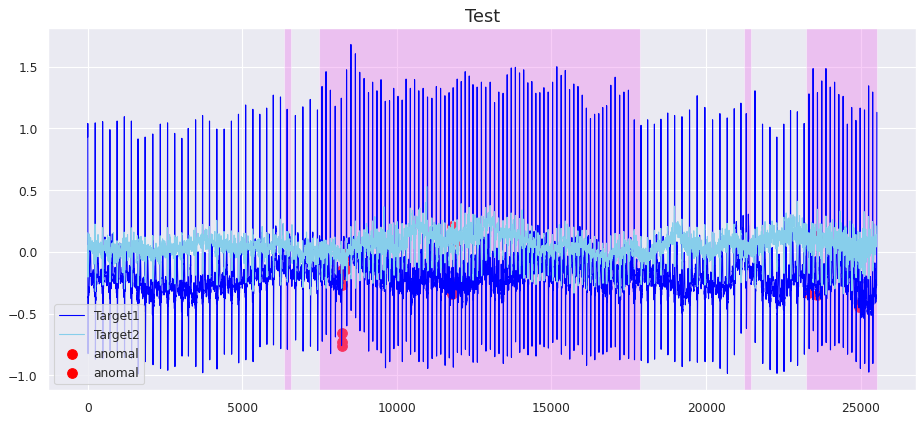

In [41]:
st_ = 0
ds_ = len(test)
test_ = test_raw[st_:ds_]
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_['Target1'], label='Target1', color='blue', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target1'].index,test_[scored['Anomaly']==1]['Target1'],label='anomal',marker='.', color='red', s = 300)

ax.plot(test_['Target2'], label='Target2', color='skyblue', animated = True, linewidth=1)
ax.scatter(test_[scored['Anomaly']==1]['Target2'].index,test_[scored['Anomaly']==1]['Target2'],label='anomal',marker='.', color='red', s = 300)

plt.legend(loc='lower left')
ax.set_title('Test', fontsize=16)

p = list(test_[test_['label'] == "1"].index)
r = list(test_[scored['Anomaly']==1]['Target1'].index)
red = []
sec = []
for i in range(len(p)):
    if len(sec) == 0:
        sec.append(p[i])
    elif sec[-1] + 1 == p[i]:
        sec.append(p[i])
    else:
        plt.axvspan(min(sec), max(sec), facecolor='violet', alpha=0.4)
        red.append(sec.copy())
        sec.clear()
        sec.append(p[i])
    if i == len(p) - 1:
        red.append(sec.copy())
        plt.axvspan(min(sec), max(sec), facecolor='violet', alpha=0.4)
plt.show()
white = [i for i in range(st_, ds_)]
r_white = []
p_red = 0
for i in range(len(red)):
    st = red[i][0] - 100
    if st < 0:
       st = 0
    if st > white[0]:
        r_white.append(white[p_red:st - st_].copy())
    p_red = red[i][-1] - st_
if white[-1] > p_red:
    r_white.append(white[p_red:white[-1]].copy())

In [42]:
mh = [False for i in range(len(red))]
FN = []
TP = []
count = 0
for i in range(len(red)):
    st = red[i][0] - 100
    if st < 0:
        st = 0
    t_red = []
    for j in range(st, red[i][-1] + 1):
        if j in r:
            mh[i] = True
            TP.append(j)
            r.remove(j)
            count+=1
        else:
            t_red.append(j)
    FN.append(t_red)

In [43]:
rh = [False for i in range(len(r_white))]
rc = 0
for i in range(len(r_white)):
    for j in r_white[i]:
        if j in r:
            rh[i] = True
            rc += 1

In [44]:
rh

[False, False, False, False]

In [45]:
FP = r.copy()

In [46]:
TP = 0
FN = 0
TN = 0
FP = 0
for i in mh:
  if i == True:
    TP+=1
  else:
    FN+=1
for i in rh:
  if i == True:
    FP+=1
  else:
    TN+=1

TP /=len(mh)
FN /=len(mh)
TN /=len(rh)
FP /=len(rh)
print("TP/TN/FP/FN",TP,TN,FP,FN)

TP/TN/FP/FN 0.5 1.0 0.0 0.5


In [47]:
Recall_=TP/(TP+FN)
Precision_=TP/(TP+FP)
Accuracy_=(TP+TN)/(TP+TN+FP+FN)
print("Recall = ",Recall_)
print("Precision = ",Precision_)
print("F1 = ",2*Precision_*Recall_/(Precision_+Recall_))
print("Accuracy = ", Accuracy_)



Recall =  0.5
Precision =  1.0
F1 =  0.6666666666666666
Accuracy =  0.75
